# Parallélisation sur CPU d'une séquence d'opérations matricielles extraites d'un modèle Llama

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from sigmulib import compute_sigmul_cpp, compute_sigmul_cython

from utils import *

torch.manual_seed(29)

## Partie 1: Visualisation de l'effet de la parallélisation

In [2]:
#List of matrices dimensions
dims = [2**i for i in range(10)]

# Dataframe to store the computation times
all_times_1 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch', 'sigmul_sequential'])

# Dataframe to store the errors w.r.t. the PyTorch version
diffs_1 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_sequential'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    # Computational time for each function
    times = compare_times(A, n_rep=10, include_sequential=True)
    for key in times.keys():
        all_times_1.loc[dim, key] = times[key]

    # Errors w.r.t. the PyTorch version
    Bt = sigmul_torch(A)
    diffs_1.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs_1.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs_1.loc[dim, 'sigmul_sequential'] = torch.abs(Bt - torch.tensor(unparallel_sigmul(A))).sum().item() / (dim**2)


100%|██████████| 10/10 [02:16<00:00, 13.63s/it]


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

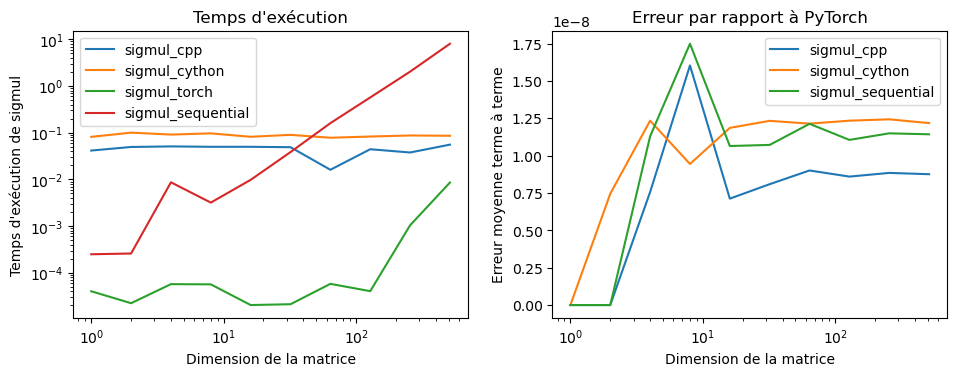

In [20]:
#Plots

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_1.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_1.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

## Partie 2: Comparaison des implémentations parallélisées de sigmul

In [21]:
dims = [2**i for i in range(15)]
all_times_2 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch'])
diffs_2 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10)
    for key in times.keys():
        all_times_2.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_2.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs_2.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


100%|██████████| 15/15 [07:20<00:00, 29.35s/it] 


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

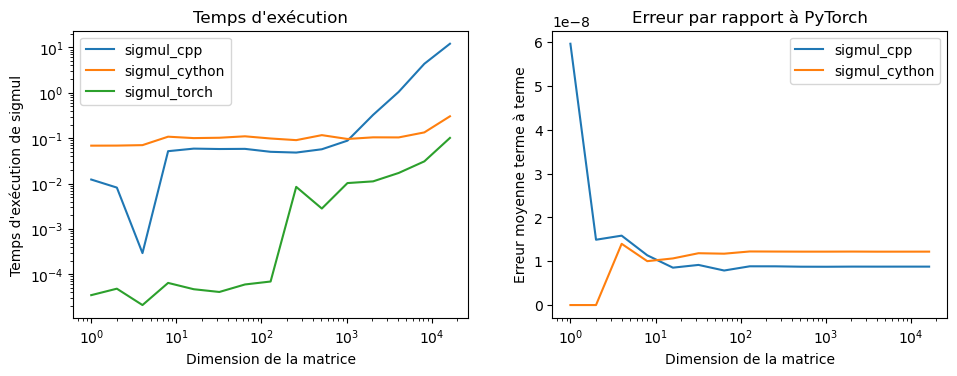

In [24]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_2.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_2.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

## Partie 3: Comparaison plus poussée des implémentations en Cython et en PyTorch 

In [2]:
dims = [2**i for i in range(16)]
all_times_3 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_torch'])
diffs_3 = pd.DataFrame(index=dims, columns=['sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10, include_cpp=False)
    for key in times.keys():
        all_times_3.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_3.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


100%|██████████| 16/16 [10:15<00:00, 38.49s/it]


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

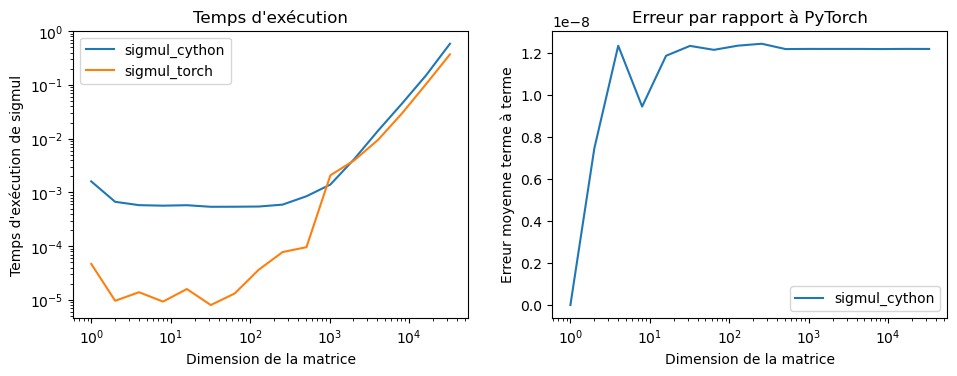

In [5]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_3.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_3.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

In [6]:
# Ratio between the execution times of sigmul_cython and sigmul_torch
all_times_3['ratio'] = all_times_3['sigmul_cython'] / all_times_3['sigmul_torch']

Text(0.5, 1.0, "Ratios des temps d'exécution")

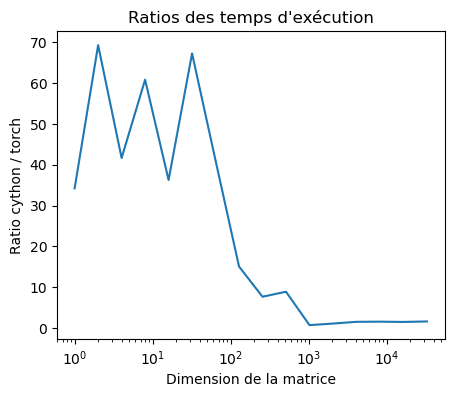

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 4)

all_times_3['ratio'].plot(logx=True, ax=ax)
ax.set_xlabel("Dimension de la matrice")
ax.set_ylabel("Ratio cython / torch")
ax.set_title("Ratios des temps d'exécution")

In [10]:
all_times_3

,sigmul_cython,sigmul_torch,ratio
1,0.001605,0.000047,34.224708
2,0.00067,0.00001,69.350617
4,0.00058,0.000014,41.667808
8,0.000567,0.000009,60.867008
16,0.000579,0.000016,36.272048
32,0.000541,0.000008,67.311573
64,0.000542,0.000013,41.050542
128,0.000547,0.000036,15.038689
256,0.000593,0.000078,7.634857
512,0.00085,0.000096,8.86176


## Partie 4: Prise en compte des temps de conversion des types entre C++ et PyTorch

In [11]:
dims = [2**i for i in range(14)]
all_times_4 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_conversions', 'sigmul_torch'])
diffs_4 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_conversions'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=20, include_cpp=False, include_conv_cython=True)
    for key in times.keys():
        all_times_4.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_4.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs_4.loc[dim, 'sigmul_cython_conversions'] = torch.abs(Bt - sigmul_from_tensor_cython(A)).sum().item() / (dim**2)


100%|██████████| 14/14 [15:43<00:00, 67.38s/it] 


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

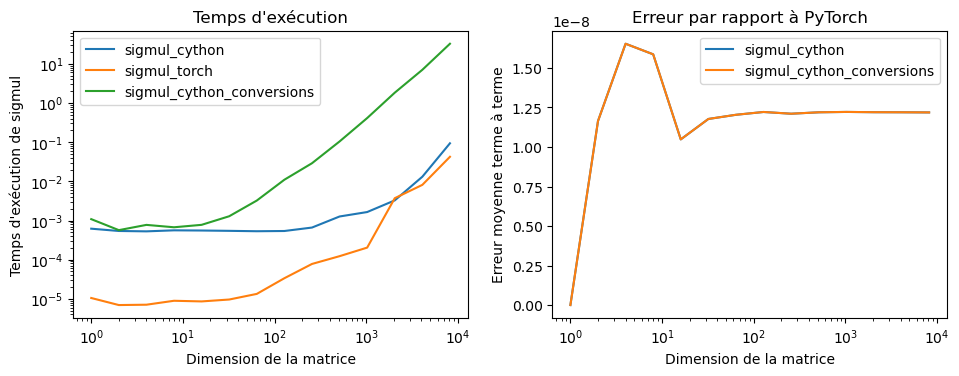

In [22]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_4.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_4.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")